#### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

#### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

#### Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

#### Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from math import sqrt

import sklearn.utils
from sklearn.preprocessing import RobustScaler #Scaling the features
from sklearn.model_selection import StratifiedShuffleSplit #Splitting the dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import GridSearchCV #hyperparameter tuning
from sklearn.decomposition import PCA

#Visual Analysis
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import IPython

from imblearn.over_sampling import ADASYN #Adaptive Synthetic Oversampling
from collections import Counter
from scipy import stats

#Neural Networks implementation
import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.constraints import maxnorm
#from tensorflow.keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')



Using TensorFlow backend.


In [3]:
#import Dataset
dataset = pd.read_csv('creditcard.csv')

In [4]:
#Number of instances and attributes,i.e., Dimensionality of the dataset
dataset.shape

(284807, 31)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
#Sum of missing cells for each attribute
dataset.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
#Number of distinct categories or classes i.e., Fraudulent and Genuine
dataset['Class'].nunique()

2

In [8]:
#number of instances per class
dataset.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

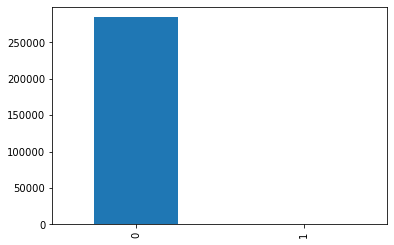

In [9]:
#visual representation of instances per class
dataset.Class.value_counts().plot.bar()

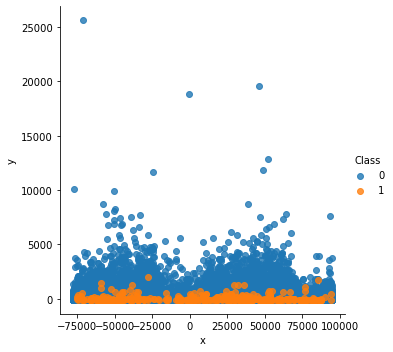

In [10]:
#Before sampling (PCA is performed for visualization only)
pca= PCA(n_components=2)
creditcard_2d= pd.DataFrame(pca.fit_transform(dataset.iloc[:,0:30]))
creditcard_2d= pd.concat([creditcard_2d, dataset['Class']], axis=1)
creditcard_2d.columns= ['x', 'y', 'Class']
sns.lmplot(x='x', y='y', data=creditcard_2d, fit_reg=False, hue='Class')

In [11]:
#Descriptive Statistics
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [12]:
#checking the percentage of each class in the dataset
(dataset.Class.value_counts())/(dataset.Class.count())

0    0.998273
1    0.001727
Name: Class, dtype: float64

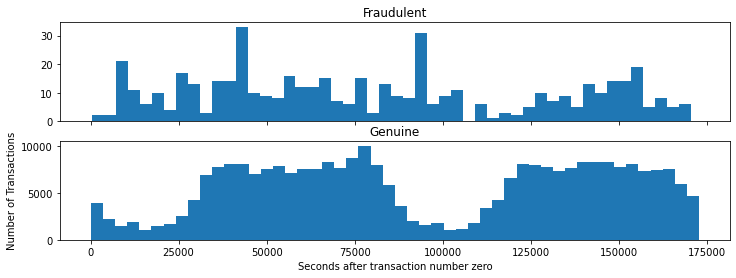

In [13]:
#Histrogram for feature Time
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

ax1.hist(dataset["Time"][dataset["Class"] == 1], bins = 50)
ax1.set_title('Fraudulent')

ax2.hist(dataset["Time"][dataset["Class"] == 0], bins = 50)
ax2.set_title('Genuine')

plt.xlabel('Seconds after transaction number zero')
plt.ylabel('Number of Transactions')
plt.show()

The transactions occur in a cyclic way. But the time feature does not provide any useful information as the time when the first transaction was initiated is not given. Thus, we'll drop this feature

In [14]:
#dropping Time because it does not give any valuable information
dataset = dataset.drop("Time", axis = 1)
dataset.shape

(284807, 30)

In [15]:
#Descriptive statistics for Fraudulent Transactions
print("Fraudulent Transactions")
dataset['Amount'][dataset['Class']==1]. describe()

Fraudulent Transactions


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [16]:
#Descriptive statistics for Genuine Transactions
print("Genuine Transactions")
dataset['Amount'][dataset['Class']==0]. describe()

Genuine Transactions


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [17]:
#Variance
dataset.var()

V1            3.836489
V2            2.726820
V3            2.299029
V4            2.004684
V5            1.905081
V6            1.774946
V7            1.530401
V8            1.426479
V9            1.206992
V10           1.185594
V11           1.041855
V12           0.998403
V13           0.990571
V14           0.918906
V15           0.837803
V16           0.767819
V17           0.721373
V18           0.702539
V19           0.662662
V20           0.594325
V21           0.539526
V22           0.526643
V23           0.389951
V24           0.366808
V25           0.271731
V26           0.232543
V27           0.162919
V28           0.108955
Amount    62560.069046
Class         0.001725
dtype: float64

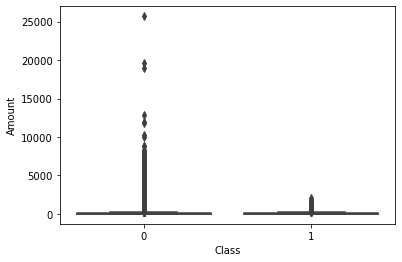

In [18]:
#Boxplot for the Amount feature, in order to visualiza the outliers.
sns.boxplot(x=dataset['Class'], y=dataset['Amount'])

The non-fraudulent instances are highly skewed. The outliers can be seen visually and thus, it's better to use a Robust Scaler to scale the feature 'Amount' as it is less prone to outliers.

In [19]:
#Standardizing the Amount column (All other 'V' columns are already scaled as they've undergone PCA transformation).
Rob_scaler=RobustScaler() #Robust to outliers
dataset['Std_Amount'] = Rob_scaler.fit_transform(dataset['Amount'].values.reshape(-1, 1))
dataset.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Std_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1.783274
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.269825
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,4.983721
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.418291
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.670579


In [20]:
#drop Amount and move Std_Amount at index '0'
dataset = dataset.drop('Amount',axis=1)

Std_Amount = dataset['Std_Amount']
dataset.drop('Std_Amount', axis=1, inplace=True)
dataset.insert(0, 'Std_Amount', Std_Amount)
dataset.head()

,Std_Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [21]:
#Splitting data before sampling
#Splitting data into train and test set in 80% and 20% respectively, using Stratified Shuffle Split

X = dataset.drop('Class', axis=1)
Y = dataset['Class']

sss1 = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index1, test_index in sss1.split(X, Y):
    print("Train:", train_index1, "Test:", test_index)
    Xtrain, Xtest = X.iloc[train_index1], X.iloc[test_index]
    Ytrain, Ytest = Y.iloc[train_index1], Y.iloc[test_index]

#Splitting the train set further into train and validation set, which leaves train set 60% of the originial dataset and, test and validation sets 20% each respectively.
sss2 = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

for train_index2, val_index in sss2.split(Xtrain, Ytrain):
    print("Train:", train_index2, "Validation:", val_index)
    Xtrain_final, Xval = X.iloc[train_index2], X.iloc[val_index]
    Ytrain_final, Yval = Y.iloc[train_index2], Y.iloc[val_index]

Train: [265518 180305  42664 ...  29062  13766  17677] Test: [263020  11378 147283 ... 274532 269819  64170]
Train: [ 72227 114282  16818 ... 264471 191914 284017] Test: [202638  32978 128121 ... 244024 127667  48318]
Train: [ 20895 114622 167683 ... 244502 178972 218506] Test: [284352  82483  90981 ... 171224 168807 271602]
Train: [122248 181660 194400 ... 104631 277586  29432] Test: [225673  63348  68025 ... 279451  77554  76043]
Train: [241684 223467 136928 ...  86495 160550  49633] Test: [157557 204860  83760 ... 251478 178967 216850]
Train: [186996 144807  69756 ... 195673 152135 100500] Validation: [214502 127768  18878 ...  45194 143895 114668]
Train: [203609 160516 170008 ... 168236  40608 156569] Validation: [152253  33885 217198 ... 219379 125093 195120]
Train: [166473 135845 190847 ... 114436 217810 119523] Validation: [135986 136793 153361 ... 221564 222657 122137]
Train: [ 16294 187750  97608 ... 157188 191303 201639] Validation: [125168  42557 218854 ... 117014  95701  40

Datasets created after splitting are:

1. Train Dataset: Xtrain_final, Ytrain_final
2. Test Dataset: Xtest, Ytest
3. Validation Dataset: Xval, Yval

In [22]:

# Check if the labels are distributed equally in all the datasets after splitting
train_unique_label, train_counts_label = np.unique(Ytrain_final, return_counts=True)
test_unique_label, test_counts_label = np.unique(Ytest, return_counts=True)
val_unique_label, val_counts_label = np.unique(Yval, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(Ytrain_final))
print(test_counts_label/ len(Ytest))
print(val_counts_label/ len(Yval))

Label Distributions: 

[0.99807471 0.00192529]
[0.99827955 0.00172045]
[0.99845511 0.00154489]


In [23]:
#Dimensionality of the datasets retrieved after splitting
print(Xtrain_final.shape)
print(Ytrain_final.shape)
print(Xtest.shape)
print(Ytest.shape)
print(Xval.shape)
print(Yval.shape)

(170883, 29)
(170883,)
(56962, 29)
(56962,)
(56962, 29)
(56962,)


Text(0.5, 1.0, 'Imbalanced Correlation Matrix')

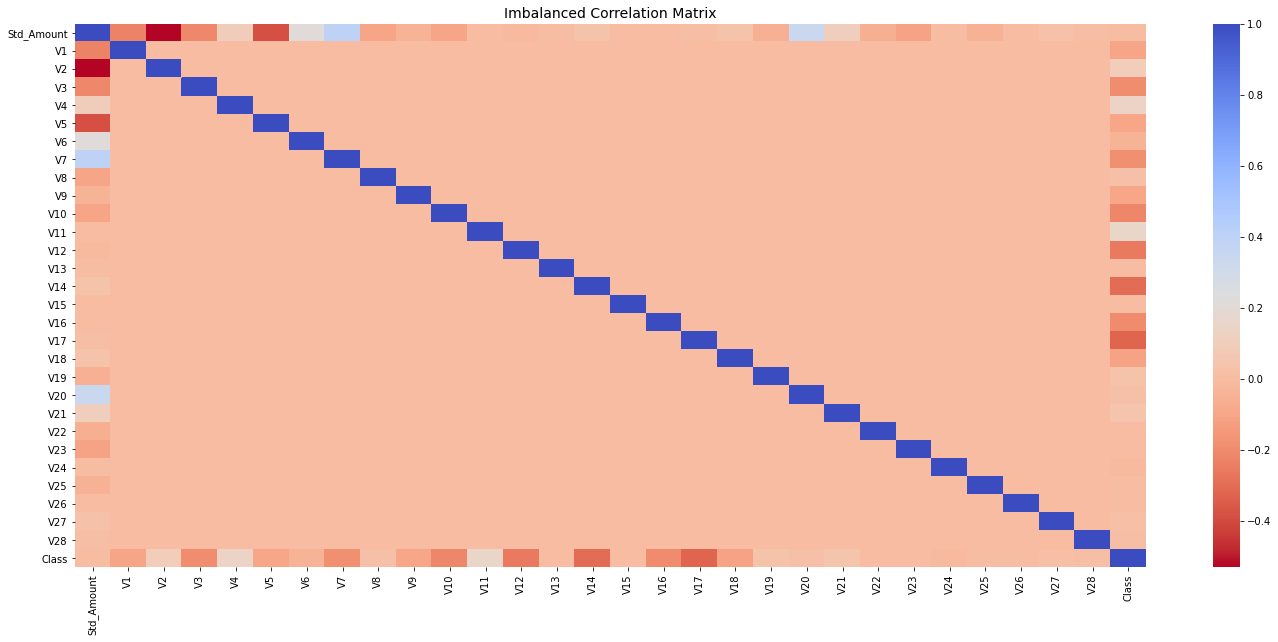

In [24]:

#checking correlation between features and the likelihood of the transaction to be fraud on the unbalanced dataset
f, ax1 = plt.subplots(figsize=(24,10))

corr = dataset.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)

In [25]:
#Checking number of instances for each class in the train dataset
print(Ytrain_final.value_counts())

0    170554
1       329
Name: Class, dtype: int64


In [26]:
#Using ADASYN for Oversampling
ada = ADASYN(sampling_strategy='minority', random_state=42)

#Oversampling is applied only on the training set
X_adasampled, Y_adasampled = ada.fit_sample(Xtrain_final, Ytrain_final)
print('Resampled dataset shape %s' % Counter(Y_adasampled))
print('Shape of X_adasampled: {}'.format(X_adasampled.shape))
print('Shape of Y_adasampled: {}'.format(Y_adasampled.shape))

Resampled dataset shape Counter({1: 170555, 0: 170554})
Shape of X_adasampled: (341109, 29)
Shape of Y_adasampled: (341109,)


In [27]:
#check the disribution of both the labels
train_label, train_count = np.unique(Y_adasampled, return_counts=True)
print('Label Distributions: \n')
print(train_count/ len(Y_adasampled))

Label Distributions: 

[0.49999853 0.50000147]


In [28]:
print(type(X_adasampled))
print(type(Y_adasampled))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [29]:
Xsm_train_df = pd.DataFrame(X_adasampled)
Xsm_train_df.columns = Xtrain.columns
Ysm_train_df = pd.DataFrame(Y_adasampled)
Ysm_train_df = Ysm_train_df.rename(columns={0: 'Class'})
print(Xsm_train_df.head())
print(Ysm_train_df.head())

   Std_Amount        V1        V2        V3        V4        V5        V6  \
0   -0.286173 -0.313555  0.586734  3.039981  2.848687 -0.158865  0.838171   
1    0.237546  1.883183 -0.640580  0.094691  0.386752 -0.859323  0.238667   
2    1.170265 -5.593796 -3.140554 -0.055757  1.539374  1.321195  1.449076   
3   -0.267729 -0.851124  0.819195  2.014788 -0.634556 -0.166583  0.779931   
4    1.369384 -1.339343  0.842304  2.210153  3.009876 -0.501056  1.506612   

         V7        V8        V9  ...       V19       V20       V21       V22  \
0 -0.305911  0.136755  1.081775  ...  0.211776  0.064667 -0.064730  0.538368   
1 -1.172713  0.238254  2.560352  ... -0.228614 -0.191241 -0.063316  0.025427   
2  0.494910 -0.187489  1.098618  ...  0.313058 -3.165442 -0.732926  1.617461   
3 -0.248282  0.440142  1.000038  ...  0.608179  0.309633  0.133497  0.615617   
4  0.044767  0.574622 -0.545759  ...  1.033634  0.245178 -0.188658 -0.159114   

        V23       V24       V25       V26       V27     

In [30]:
#Merging the Xsm_train_df and Ysm_train_df based on the index values to get a single dataframe in order to visualize a correlation matrix
new_df= pd.merge(Xsm_train_df, Ysm_train_df, how='inner', left_index=True, right_index=True)
new_df.head()

,Std_Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.286173,-0.313555,0.586734,3.039981,2.848687,-0.158865,0.838171,-0.305911,0.136755,1.081775,...,0.064667,-0.064730,0.538368,0.017643,0.514390,-0.970922,-0.131954,0.072962,-0.014056,0
1,0.237546,1.883183,-0.640580,0.094691,0.386752,-0.859323,0.238667,-1.172713,0.238254,2.560352,...,-0.191241,-0.063316,0.025427,0.346800,0.700140,-0.686270,0.387537,-0.060475,-0.044121,0
2,1.170265,-5.593796,-3.140554,-0.055757,1.539374,1.321195,1.449076,0.494910,-0.187489,1.098618,...,-3.165442,-0.732926,1.617461,1.182141,-1.534997,0.203254,-0.308358,-0.982457,-0.584698,0
3,-0.267729,-0.851124,0.819195,2.014788,-0.634556,-0.166583,0.779931,-0.248282,0.440142,1.000038,...,0.309633,0.133497,0.615617,-0.475375,0.010686,0.582486,-0.302416,0.486000,0.209563,0
4,1.369384,-1.339343,0.842304,2.210153,3.009876,-0.501056,1.506612,0.044767,0.574622,-0.545759,...,0.245178,-0.188658,-0.159114,-0.241138,-0.402550,0.057283,0.231537,0.067849,-0.249524,0


Text(0.5, 1.0, 'Balanced Correlation Matrix')

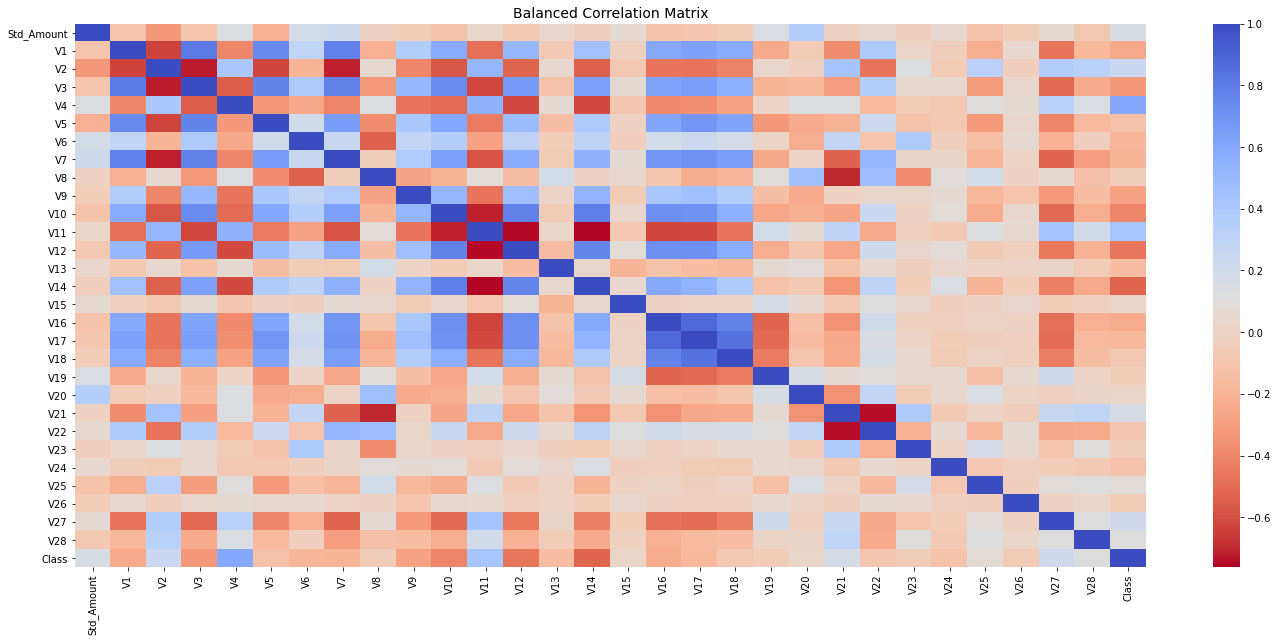

In [31]:

#checking correlation between features on the balanced dataset
f, ax1 = plt.subplots(figsize=(24,10))

corr = new_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Balanced Correlation Matrix", fontsize=14)

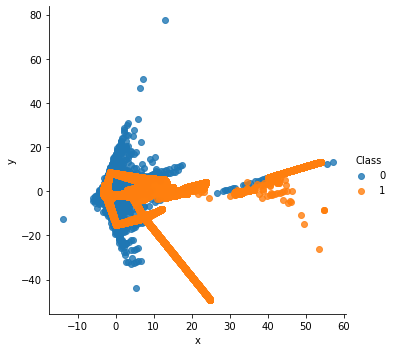

In [32]:
#visualizing balanced train dataset
X_df= pd.DataFrame(X_adasampled)
Y_df= pd.DataFrame(Y_adasampled)
Y_df=Y_df.rename(columns={0: 'Class'})
train_2d= pd.DataFrame(pca.fit_transform(X_df.iloc[:,0:29]))
train_2d= pd.concat([train_2d, Y_df], axis=1)
train_2d.columns= ['x', 'y', 'Class']
sns.lmplot(x='x', y='y', data=train_2d, fit_reg=False, hue='Class')

In [33]:
#An undersampled dataset is created to tune the parameters using Grid-Search
Ytrain_df = pd.DataFrame(Ytrain_final)
Ytrain_df = Ytrain_df.rename(columns={0: 'Class'})
Train_set= pd.merge(Xtrain_final, Ytrain_df, how='inner', left_index=True, right_index=True)
Train_set.head()

,Std_Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
14162,-0.286173,-0.313555,0.586734,3.039981,2.848687,-0.158865,0.838171,-0.305911,0.136755,1.081775,...,0.064667,-0.064730,0.538368,0.017643,0.514390,-0.970922,-0.131954,0.072962,-0.014056,0
152802,0.237546,1.883183,-0.640580,0.094691,0.386752,-0.859323,0.238667,-1.172713,0.238254,2.560352,...,-0.191241,-0.063316,0.025427,0.346800,0.700140,-0.686270,0.387537,-0.060475,-0.044121,0
227171,1.170265,-5.593796,-3.140554,-0.055757,1.539374,1.321195,1.449076,0.494910,-0.187489,1.098618,...,-3.165442,-0.732926,1.617461,1.182141,-1.534997,0.203254,-0.308358,-0.982457,-0.584698,0
217316,-0.267729,-0.851124,0.819195,2.014788,-0.634556,-0.166583,0.779931,-0.248282,0.440142,1.000038,...,0.309633,0.133497,0.615617,-0.475375,0.010686,0.582486,-0.302416,0.486000,0.209563,0
80544,1.369384,-1.339343,0.842304,2.210153,3.009876,-0.501056,1.506612,0.044767,0.574622,-0.545759,...,0.245178,-0.188658,-0.159114,-0.241138,-0.402550,0.057283,0.231537,0.067849,-0.249524,0


In [34]:
Train_set.shape

(170883, 30)

In [35]:
#Length of Frauds
length_frauds=len(Train_set[Train_set.Class==1])
length_frauds

329

In [36]:
#Taking only Frauds in a dataframe
fraud_df= Train_set.loc[Train_set['Class'] == 1]
fraud_df.head()

,Std_Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
143188,-0.279466,-3.003459,2.096150,-0.487030,3.069453,-1.774329,0.251804,-4.328776,-2.425478,-0.985222,...,0.692537,0.163967,1.245648,-0.269241,0.537102,-0.220757,-0.059555,0.460710,-0.033551,1
86155,1.110878,-2.756007,0.683821,-1.390169,1.501887,-1.165614,-0.131207,-1.478741,-0.246922,-0.100523,...,-0.106945,0.320474,0.611027,0.174864,-0.502151,-0.174713,1.179242,-1.166315,0.821215,1
9487,-0.293440,-4.153014,8.204797,-15.031714,10.330100,-3.994426,-3.250013,-10.415698,4.620804,-5.711248,...,1.412625,1.976988,0.256510,0.485908,-1.198821,-0.526567,0.634874,1.627209,0.723235,1
163586,0.600852,0.949241,1.333519,-4.855402,1.835006,-1.053245,-2.562826,-2.286986,0.260906,-0.895366,...,0.424608,0.306598,-0.854627,0.101177,-0.281497,0.024444,-0.107944,0.625289,0.315677,1
223578,-0.183050,-5.256434,0.364541,-5.412085,2.400031,0.697301,-1.998755,-5.835532,-0.887739,-2.828287,...,-0.403685,-0.648259,0.511285,-1.110045,0.178987,0.220235,-0.699809,0.580487,-0.173630,1


In [37]:

#Taking only Non-frauds
non_fraud_df= Train_set.loc[Train_set['Class'] == 0]
#Randomly select the same number of records as the Frauds
non_frauds=non_fraud_df.sample(n=length_frauds)
non_frauds.shape

(329, 30)

In [38]:
#Appending both Frauds and Non-Frauds
undersampled_df= fraud_df.append(non_frauds)
#Randomly shuffling all the instances
undersampled_df = sklearn.utils.shuffle(undersampled_df)
undersampled_df.head()

,Std_Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
42473,-0.254454,-3.600544,4.519047,-6.340884,6.214767,-5.829558,-2.478095,-9.938412,2.830086,-5.659162,...,1.384743,2.263770,0.620749,-0.094069,0.536719,0.398142,0.008277,2.053524,0.835749,1
102782,-0.033676,1.232604,-0.548931,1.087873,0.894082,-1.433055,-0.356797,-0.717492,0.003167,-0.100397,...,-0.576274,-0.448671,-0.517568,0.012833,0.699217,0.527258,-0.322607,0.080805,0.035427,1
139159,-0.217984,-0.691500,1.064111,1.131949,0.845470,-0.167266,-0.660122,0.394746,0.222811,-0.646601,...,-0.162351,0.210374,0.538242,-0.160603,0.514264,-0.392376,-0.399678,-0.246744,-0.160095,0
81609,19.109341,-2.326922,-3.348439,-3.513408,3.175060,-2.815137,-0.203363,-0.892144,0.333226,-0.802005,...,3.209171,1.226648,-0.695902,-1.478490,-0.061553,0.236155,0.531911,0.302324,0.536375,1
69498,-0.195626,0.385108,1.217620,-1.953872,2.087076,-1.144225,-0.576888,-2.582865,0.643230,-1.191233,...,0.380545,0.594623,0.372144,-0.310456,-0.624065,0.840216,-0.159452,0.599482,0.288916,1


In [39]:
#Separating labels from the other features
X_undersample = undersampled_df.drop('Class', axis=1)
Y_undersample = undersampled_df['Class']
print(X_undersample.shape)
print(Y_undersample.shape)

(658, 29)
(658,)


In [40]:
#Converting undersampled train sets in numpy arrays
X_us_arr= X_undersample.values
Y_us_arr= Y_undersample.values

In [41]:
#Converting test and validation dataframes in numpy arrays
Xval_arr=Xval.values
Yval_arr=Yval.values
Xtest_arr=Xtest.values
Ytest_arr=Ytest.values

In [42]:
#Training a Multi-layer perceptron with 1 hidden layer on Oversampled dataset without using dropout and, using the parameters tuned above.
n_inputs = X_adasampled.shape[1]
#es= keras.callbacks.EarlyStopping(monitor='val_loss',
                              #min_delta=0,
                              #patience=2,
                              #verbose=0, mode='min', restore_best_weights= True)
#Model Creation
Model1 = Sequential()
Model1.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
Model1.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

#Compile Model
Model1.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
Model1.summary()

#Fit Model
history1= Model1.fit(X_adasampled, Y_adasampled, validation_data=(Xval_arr, Yval_arr), batch_size=700, epochs=30,  shuffle=True, verbose=2)
print(history1.history.keys())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65)                1950      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 66        
Total params: 2,016
Trainable params: 2,016
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
488/488 - 1s - loss: 0.0510 - accuracy: 0.9849 - val_loss: 0.0147 - val_accuracy: 0.9962
Epoch 2/30
488/488 - 1s - loss: 0.0098 - accuracy: 0.9981 - val_loss: 0.0114 - val_accuracy: 0.9976
Epoch 3/30
488/488 - 1s - loss: 0.0073 - accuracy: 0.9987 - val_loss: 0.0116 - val_accuracy: 0.9983
Epoch 4/30
488/488 - 1s - loss: 0.0050 - accuracy: 0.9992 - val_loss: 0.0092 - val_accuracy: 0.9986
Epoch 5/30
488/488 - 1s - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.0086 - val_accuracy: 0.9987
Epoch 6/30
488/4

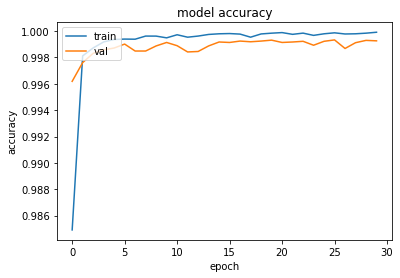

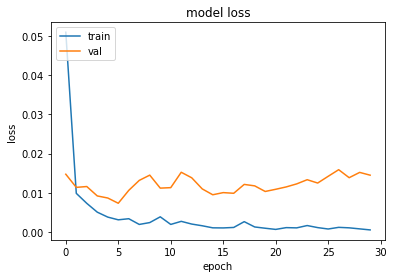

In [43]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
#Training a Multi-layer perceptron with 1 hidden layer on Oversampled dataset using the parameters tuned above and adding a Dropout.
n_inputs = X_adasampled.shape[1]
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='min', restore_best_weights= True)
Model1_drop = Sequential()
Model1_drop.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
Model1_drop.add(Dropout(0.5))
Model1_drop.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

Model1_drop.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
Model1_drop.summary()

history2= Model1_drop.fit(X_adasampled, Y_adasampled, validation_data=(Xval_arr, Yval_arr), batch_size=700, epochs=40, callbacks=[es], shuffle=True, verbose=2)
print(history2.history.keys())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 65)                1950      
_________________________________________________________________
dropout (Dropout)            (None, 65)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 66        
Total params: 2,016
Trainable params: 2,016
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
488/488 - 1s - loss: 0.3317 - accuracy: 0.8721 - val_loss: 0.1381 - val_accuracy: 0.9569
Epoch 2/40
488/488 - 1s - loss: 0.1391 - accuracy: 0.9551 - val_loss: 0.0796 - val_accuracy: 0.9745
Epoch 3/40
488/488 - 1s - loss: 0.0904 - accuracy: 0.9757 - val_loss: 0.0576 - val_accuracy: 0.9808
Epoch 4/40
488/488 - 1s - loss: 0.0664 - accuracy: 0.9841 - val_loss: 0.0425 - val

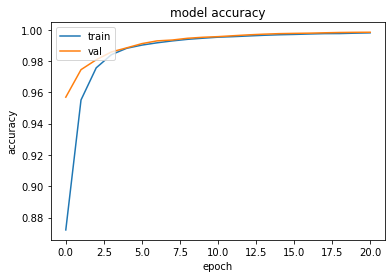

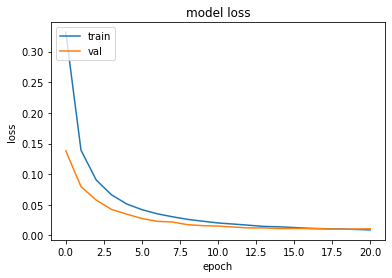

In [45]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
#function for confusion matrix
def conf_matrix(predicted_values):
    Predictions_CM = confusion_matrix(Ytest_arr, predicted_values, labels = [0, 1])
    class_feat=dataset['Class'].copy()
    class_feat= class_feat.unique()
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(Predictions_CM, annot=True, fmt='d', xticklabels=class_feat, yticklabels=class_feat)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
1781/1781 [==============================] - 2s 984us/step - loss: 0.0076 - accuracy: 0.9983
Accuracy Model1 (Dropout): 0.9982619881629944
Recall_score: 0.9489795918367347
Precision_score: 0.49732620320855614
F-score: 0.6526315789473683


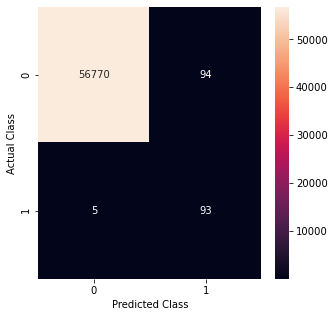

In [47]:
Y_pred_cls = Model1_drop.predict_classes(Xtest_arr, batch_size=200, verbose=0)
print('Accuracy Model1 (Dropout): '+ str(Model1_drop.evaluate(Xtest_arr,Ytest_arr)[1]))
print('Recall_score: ' + str(recall_score(Ytest_arr,Y_pred_cls)))
print('Precision_score: ' + str(precision_score(Ytest_arr, Y_pred_cls)))
print('F-score: ' + str(f1_score(Ytest_arr,Y_pred_cls)))
conf_matrix(Y_pred_cls)

Instructions for updating:
Please use `model.predict()` instead.


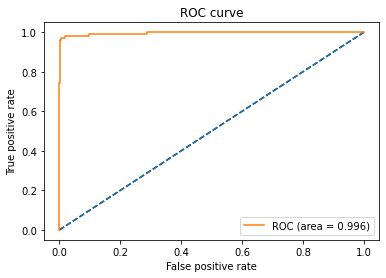

In [48]:
#Plotting ROC curve
Y_pred_prob = Model1_drop.predict_proba(Xtest_arr).ravel()

fpr_model1, tpr_model1, thresholds_model1 = roc_curve(Ytest_arr, Y_pred_prob, pos_label=1)
auc_model1 = roc_auc_score(Ytest_arr, Y_pred_prob)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
#plot the roc curve for the model
plt.plot(fpr_model1, tpr_model1, label='ROC (area = {:.3f})'.format(auc_model1))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

ROC curves are generally not well suited for imbalanced datasets, as they make use of TN. Thus, they can be deceptive. In contrast, TN are not considered in the PR-curve. Hence, they are more suitable for an imbalanced classification.

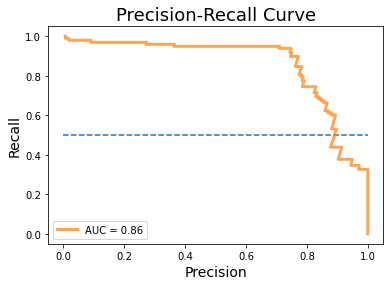

In [49]:
#Calculating Precision and Recall for various thresholds
precision, recall, thresholds_pr = precision_recall_curve(Ytest_arr, Y_pred_prob)

#Auc for PR curve
AUC_PRcurve= auc(recall, precision)

plt.figure(1)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
#plot PR curve
plt.plot(precision, recall, label = "AUC = {:0.2f}".format(AUC_PRcurve), lw = 3, alpha = 0.7)
plt.xlabel('Precision', fontsize = 14)
plt.ylabel('Recall', fontsize = 14)
plt.title('Precision-Recall Curve', fontsize = 18)
plt.legend(loc='best')
plt.show()

In [50]:
#Training Multi-layer Perceptron with single hidden layer for 60 iterations and, appending the F-score for each iteration.
f_scorelist1=[]

n_inputs = X_adasampled.shape[1]
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='min', restore_best_weights= True)
for i in range(0,60):
    First_Model = Sequential()
    First_Model.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
    First_Model.add(Dropout(0.5))
    First_Model.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

    First_Model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    First_Model.fit(X_adasampled, Y_adasampled, validation_data=(Xval_arr, Yval_arr), batch_size=700, epochs=40, callbacks=[es], shuffle=True, verbose=0)
    Y_first_pred = First_Model.predict_classes(Xtest_arr, batch_size=200, verbose=0)
    
    f_score= f1_score(Ytest_arr,Y_first_pred)
    f_scorelist1.append(f_score)

print(f_scorelist1)
print('FScore Mean: '+ str(np.mean(f_scorelist1)))
print('-'*88)

[0.6086956521739131, 0.6595744680851063, 0.6838235294117647, 0.6503496503496504, 0.7045454545454546, 0.6188925081433224, 0.5949367088607596, 0.6596491228070176, 0.657243816254417, 0.6064516129032258, 0.6643109540636042, 0.6372881355932204, 0.5792682926829268, 0.6433566433566433, 0.5893416927899686, 0.6123778501628665, 0.5723076923076923, 0.7022900763358778, 0.6937269372693725, 0.6112956810631229, 0.6287625418060201, 0.632996632996633, 0.6433566433566433, 0.6762589928057555, 0.6666666666666667, 0.6440677966101696, 0.6372881355932204, 0.6148867313915858, 0.47029702970297027, 0.6666666666666667, 0.5993485342019544, 0.6594982078853047, 0.5723076923076923, 0.6482758620689655, 0.6666666666666666, 0.6737588652482269, 0.6550522648083624, 0.6397306397306397, 0.6549295774647887, 0.632996632996633, 0.6943396226415095, 0.636986301369863, 0.5696594427244582, 0.6482758620689655, 0.6312292358803986, 0.6351351351351352, 0.6089743589743589, 0.6789667896678966, 0.6503496503496504, 0.6372881355932204, 0.

In [51]:

#Training Multi-layer perceptron with 2 hidden layers
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='min', restore_best_weights= True)
Model2 = Sequential()
Model2.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
Model2.add(Dropout(0.5))
Model2.add(Dense(65, kernel_initializer='he_normal', activation='relu'))
Model2.add(Dropout(0.5))
Model2.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

Model2.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
his_mod2= Model2.fit(X_adasampled, Y_adasampled, validation_data=(Xval_arr, Yval_arr), batch_size=700, epochs=40, callbacks=[es], shuffle=True, verbose=2)
print(his_mod2.history.keys())

Epoch 1/40
488/488 - 2s - loss: 0.4213 - accuracy: 0.8362 - val_loss: 0.1287 - val_accuracy: 0.9479
Epoch 2/40
488/488 - 2s - loss: 0.1395 - accuracy: 0.9532 - val_loss: 0.0562 - val_accuracy: 0.9785
Epoch 3/40
488/488 - 2s - loss: 0.0722 - accuracy: 0.9805 - val_loss: 0.0294 - val_accuracy: 0.9906
Epoch 4/40
488/488 - 2s - loss: 0.0442 - accuracy: 0.9890 - val_loss: 0.0208 - val_accuracy: 0.9944
Epoch 5/40
488/488 - 2s - loss: 0.0305 - accuracy: 0.9929 - val_loss: 0.0169 - val_accuracy: 0.9962
Epoch 6/40
488/488 - 2s - loss: 0.0233 - accuracy: 0.9948 - val_loss: 0.0147 - val_accuracy: 0.9969
Epoch 7/40
488/488 - 2s - loss: 0.0187 - accuracy: 0.9960 - val_loss: 0.0134 - val_accuracy: 0.9976
Epoch 8/40
488/488 - 2s - loss: 0.0155 - accuracy: 0.9968 - val_loss: 0.0127 - val_accuracy: 0.9980
Epoch 9/40
488/488 - 2s - loss: 0.0137 - accuracy: 0.9973 - val_loss: 0.0124 - val_accuracy: 0.9985
Epoch 10/40
488/488 - 2s - loss: 0.0123 - accuracy: 0.9976 - val_loss: 0.0116 - val_accuracy: 0.9987

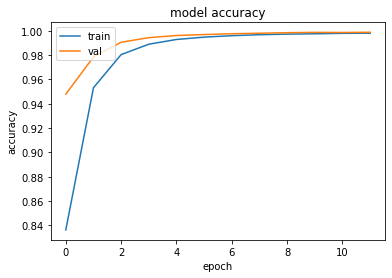

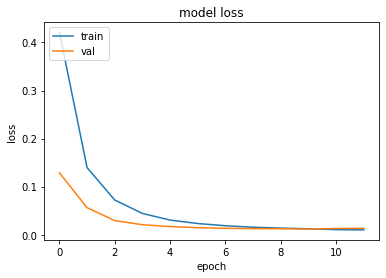

In [53]:
# summarize history for accuracy
plt.plot(his_mod2.history['accuracy'])
plt.plot(his_mod2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(his_mod2.history['loss'])
plt.plot(his_mod2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1781/1781 [==============================] - 2s 847us/step - loss: 0.0076 - accuracy: 0.9985
Accuracy MLP: 0.9985077977180481
1781/1781 [==============================] - 1s 757us/step - loss: 0.0076 - accuracy: 0.9985
Loss value: 0.007560070604085922
Recall_score: 0.9489795918367347
Precision_score: 0.5375722543352601
F-score: 0.6863468634686347


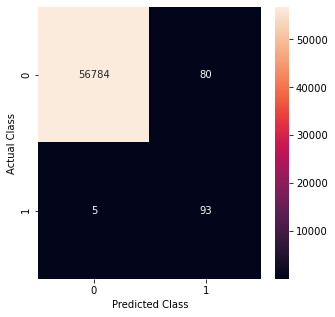

In [54]:
print('Accuracy MLP: '+ str(Model2.evaluate(Xtest_arr,Ytest_arr)[1]))
print('Loss value: '+ str(Model2.evaluate(Xtest_arr,Ytest_arr)[0]))

Y_mod2_pred = Model2.predict_classes(Xtest_arr, batch_size=200, verbose=0)
print('Recall_score: ' + str(recall_score(Ytest_arr,Y_mod2_pred)))
print('Precision_score: ' + str(precision_score(Ytest_arr, Y_mod2_pred)))
print('F-score: ' + str(f1_score(Ytest_arr,Y_mod2_pred)))
conf_matrix(Y_mod2_pred)

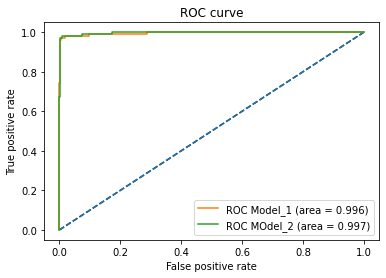

In [55]:
Y_pred_prob2 = Model2.predict_proba(Xtest_arr).ravel()

fpr_model2, tpr_model2, thresholds_model2 = roc_curve(Ytest_arr, Y_pred_prob2, pos_label=1)
auc_model2 = roc_auc_score(Ytest_arr, Y_pred_prob2)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
#plot the roc curve for the model
plt.plot(fpr_model1, tpr_model1, label='ROC Model_1 (area = {:.3f})'.format(auc_model1))
plt.plot(fpr_model2, tpr_model2, label='ROC MOdel_2 (area = {:.3f})'.format(auc_model2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

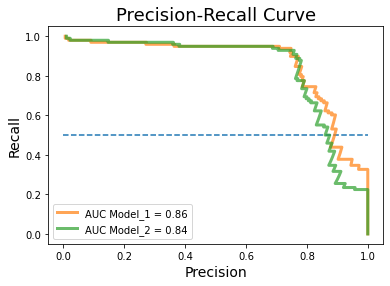

In [56]:

#Calculating Precision and Recall for various thresholds
precision_2, recall_2, thresholds_pr_2 = precision_recall_curve(Ytest_arr, Y_pred_prob2)

#Auc for PR curve
AUC_PRcurve_2= auc(recall_2, precision_2)

plt.figure(1)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
#plot PR curve
plt.plot(precision, recall, label = "AUC Model_1 = {:0.2f}".format(AUC_PRcurve), lw = 3, alpha = 0.7)
plt.plot(precision_2, recall_2, label = "AUC Model_2 = {:0.2f}".format(AUC_PRcurve_2), lw = 3, alpha = 0.7)
plt.xlabel('Precision', fontsize = 14)
plt.ylabel('Recall', fontsize = 14)
plt.title('Precision-Recall Curve', fontsize = 18)
plt.legend(loc='best')
plt.show()

In [58]:
#Iterating Model-2 with 2 hidden layer for 60 iterations.

f_scorelist2=[]

n_inputs = X_adasampled.shape[1]
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='min', restore_best_weights= True)
for i in range(0,60):
    
    Second_Model = Sequential()
    Second_Model.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
    Second_Model.add(Dropout(0.5))
    Second_Model.add(Dense(65, kernel_initializer='he_normal', activation='relu'))
    Second_Model.add(Dropout(0.5))
    Second_Model.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

    Second_Model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    Second_Model.fit(X_adasampled, Y_adasampled, validation_data=(Xval_arr, Yval_arr), batch_size=700, epochs=40, callbacks=[es], shuffle=True, verbose=0)
    Y_second_pred = Second_Model.predict_classes(Xtest_arr, batch_size=200, verbose=0)
    
    f_score= f1_score(Ytest_arr,Y_second_pred)
    f_scorelist2.append(f_score)

print(f_scorelist2)
print('FScore Mean: '+ str(np.mean(f_scorelist2)))
print('-'*88)

[0.6506849315068494, 0.6505190311418686, 0.6438356164383561, 0.6594982078853047, 0.6344827586206897, 0.6462585034013605, 0.6763636363636365, 0.5820433436532507, 0.7049808429118775, 0.5980707395498392, 0.6917293233082707, 0.681159420289855, 0.6270627062706271, 0.6940298507462687, 0.611842105263158, 0.6713780918727914, 0.6643109540636042, 0.6548042704626335, 0.6506849315068494, 0.6763636363636365, 0.683453237410072, 0.7272727272727273, 0.673913043478261, 0.6619718309859155, 0.662020905923345, 0.6464646464646464, 0.6594982078853047, 0.6225165562913907, 0.6737588652482269, 0.6838235294117647, 0.6262626262626263, 0.6433566433566433, 0.6666666666666666, 0.6506849315068494, 0.6861313868613138, 0.6962962962962962, 0.662020905923345, 0.6619718309859155, 0.676470588235294, 0.6737588652482269, 0.6075949367088608, 0.6270627062706271, 0.6148867313915858, 0.6225165562913907, 0.6270627062706271, 0.6394557823129252, 0.6934306569343065, 0.6266666666666667, 0.7041198501872659, 0.6596491228070176, 0.5838

In [59]:
#Comparing the mean performance of the F-score for both the models
print('Model-1')
print('---------')
print('Average F-Score: '+ str(np.mean(f_scorelist1)))

print('-'*40)

print('Model-2')
print('---------')
print('Average F-Score: '+ str(np.mean(f_scorelist2)))

Model-1
---------
Average F-Score: 0.6366642130059558
----------------------------------------
Model-2
---------
Average F-Score: 0.6538960006735614


In [60]:
#Comparing the Standard Deviation for F-scores generated after iterations
fscore_df1=pd.DataFrame(f_scorelist1)

print('Model-1')
print('------------------')
print('F_score SD: ' + str(fscore_df1.std()))

print('-'*40)

fscore_df2=pd.DataFrame(f_scorelist2)

print('Model-2')
print('------------------')
print('F_score SD: ' + str(fscore_df2.std()))

Model-1
------------------
F_score SD: 0    0.039663
dtype: float64
----------------------------------------
Model-2
------------------
F_score SD: 0    0.031745
dtype: float64


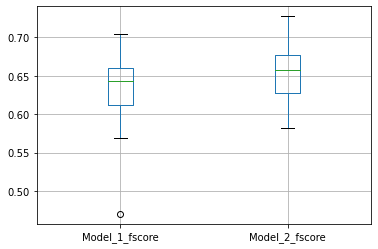

In [61]:
#Visualize the results using a boxplot()

results_fscore= pd.concat([fscore_df1, fscore_df2], axis=1)
results_fscore.columns = ['Model_1_fscore', 'Model_2_fscore']

results_fscore.boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017EAD03E1C8>,
      dtype=object)

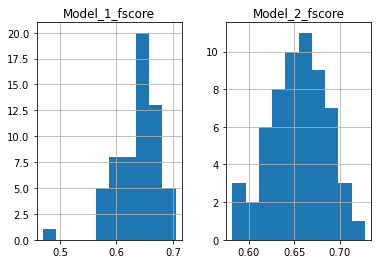

In [63]:
#Distribution of the data using a Histogram
results_fscore.hist()

In [65]:
#Testing the Null Hypothesis that a sample comes from a Normal Distribution
alpha = 0.05;

s, p = stats.normaltest(fscore_df1)
if p < alpha:
    print('Model-1 Data is not normal')
else:
    print('Model-1 Data is normal')

s, p = stats.normaltest(fscore_df2)
if p < alpha:
    print('Model-2 Data is not normal')
else:
    print('Model-2 Data is normal')

Model-1 Data is not normal
Model-2 Data is normal


In [67]:
#Wilcoxon Signed-Rank Test
#It tests the null hypothesis that two related paired samples come from the same distribution.
#It is a non-parametric version of the paired T-test.

s, p = stats.wilcoxon(fscore_df1[0], fscore_df2[0])

if p < 0.05:
    print('null hypothesis rejected, significant difference between the data-sets')
else:
    print('null hypothesis accepted, no significant difference between the data-sets')

null hypothesis rejected, significant difference between the data-sets
